<a href="https://colab.research.google.com/github/Danika-Balas/msds-458/blob/master/PCam_110.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Data is a modified version of the PCam dataset--duplicates have been removed. The goal is to classify the images as cancerous or non-cancerous. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.
https://www.kaggle.com/c/histopathologic-cancer-detection/data?select=train_labels.csv 

###Acknowledgements
Code was adapted from the following sources:

Deep Learning with Python by Francis Chollet

https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93

https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing

https://www.kaggle.com/artgor/simple-eda-and-model-in-pytorch


#Setup and Preprocessing

In [0]:
import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
#%matplotlib inline
#sns.set(style="whitegrid")

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

import os, random
from random import shuffle
import cv2 #image processing
from glob import glob #for easily finding matching filenames 
from tqdm import tqdm, tqdm_notebook, trange #progress bar
import gc #garbage collection, for saving RAM

import tensorflow as tf
from tensorflow import keras
keras.__version__

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'2.3.0-tf'

In [0]:
from keras import metrics
from keras import models
from keras import layers

Using TensorFlow backend.


##Upload data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Code executed once to unzip the files, then commented out:

In [0]:
# #unzip set of training files (smaller dataset to make sure it works)
# !unzip -uq "/content/drive/My Drive/MSDS 458/PCam/sampleTrain.zip" -d "/content/drive/My Drive/MSDS 458/PCam/unzipped/sampleTrain"

In [0]:
#Check whether sample files are readable
sample_names = os.listdir('/content/drive/My Drive/MSDS 458/PCam/unzipped/sampleTrain/sampleTrain')
print(f'{len(sample_names)} files in sample directory')
print(sample_names[:5])

10 files in sample directory
['00a0ad1de2cdf805f02c524a985bca5bce1d1b5f.tif', '0a0a8bdf1d78af77dcc0b94aef6fb5c2f841a3c0.tif', '0a0a2e923bdedb11f270dcd3f11d0f001df98f00.tif', '0a0d1a09e5cf9fcc308ecdc210450aecd204d344.tif', '0a0b4604d66cecfe668e26383c22fafb74484eef.tif']


Started with 10,000 training files in order develop model

Be sure to change path below when adding more files

In [0]:
# #unzip set of training files
# !unzip -uq "/content/drive/My Drive/MSDS 458/PCam/train80P.zip" -d "/content/drive/My Drive/MSDS 458/PCam/unzipped/train"

In [0]:
# drive.mount("/content/drive", force_remount=True)

In [0]:
#Check whether sample files are readable
train_names = os.listdir('/content/drive/My Drive/MSDS 458/PCam/unzipped/train/train80P')
print(f'{len(train_names)} files in training directory')
print(train_names[:5])

80000 files in training directory
['9e95058fb893e190f7c37981ca39a8acc54324af.tif', '4edce49c86f8e5c205faa4df4547a6f448f66448.tif', '7e2c17f2334d576e7c21ca7b9eda571dd7344b8e.tif', '37f0d8cc90045cfe381b8000b8fbc5637c564778.tif', '12dcdcdc4b6850cc15639796de8b25ae86080476.tif']


Code below to unzip testing data. It has not been run yet it order to save space on Drive.

In [0]:
# #unzip set of testing files 
# !unzip -uq "/content/drive/My Drive/MSDS 458/PCam/test.zip" -d "/content/drive/My Drive/MSDS 458/PCam/unzipped/test"

In [0]:
# #Check whether sample files are readable
# test_names = os.listdir('/content/drive/My Drive/MSDS 458/PCam/unzipped/test')
# print(f'{len(test_names)} files in testing directory')
# print(test_names[:5])

##Set paths

In [0]:
path = '/content/drive/My Drive/MSDS 458/PCam/unzipped/'
train_path = path+'train/train80P'
test_path =  path+'test/'
sample_path = path+'sampleTrain/sampleTrain'  #contains 10 images, simply for testing data can be read
val_path = path+ 'train/train10'

##Load labels and filenames

In [0]:
labels = pd.read_csv('/content/drive/My Drive/MSDS 458/PCam/train_labels.csv')

In [0]:
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
df['id'] = df.path.map(lambda x: x.split('/')[9].split(".")[0]) # keep only the file names in 'id'
df.head()

,path,id
0,/content/drive/My Drive/MSDS 458/PCam/unzipped...,9e95058fb893e190f7c37981ca39a8acc54324af
1,/content/drive/My Drive/MSDS 458/PCam/unzipped...,4edce49c86f8e5c205faa4df4547a6f448f66448
2,/content/drive/My Drive/MSDS 458/PCam/unzipped...,7e2c17f2334d576e7c21ca7b9eda571dd7344b8e
3,/content/drive/My Drive/MSDS 458/PCam/unzipped...,37f0d8cc90045cfe381b8000b8fbc5637c564778
4,/content/drive/My Drive/MSDS 458/PCam/unzipped...,12dcdcdc4b6850cc15639796de8b25ae86080476


In [0]:
df = df.merge(labels, on = "id") # merge labels and filepaths

In [0]:
df.head(5) # print the first five entries

,path,id,label
0,/content/drive/My Drive/MSDS 458/PCam/unzipped...,9e95058fb893e190f7c37981ca39a8acc54324af,0
1,/content/drive/My Drive/MSDS 458/PCam/unzipped...,4edce49c86f8e5c205faa4df4547a6f448f66448,1
2,/content/drive/My Drive/MSDS 458/PCam/unzipped...,7e2c17f2334d576e7c21ca7b9eda571dd7344b8e,0
3,/content/drive/My Drive/MSDS 458/PCam/unzipped...,37f0d8cc90045cfe381b8000b8fbc5637c564778,1
4,/content/drive/My Drive/MSDS 458/PCam/unzipped...,12dcdcdc4b6850cc15639796de8b25ae86080476,0


In [0]:
print(df.count) #check total number of rows in dataframe

<bound method DataFrame.count of                                                     path  ... label
0      /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
1      /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
2      /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
3      /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
4      /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
...                                                  ...  ...   ...
79994  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
79995  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
79996  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
79997  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
79998  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0

[79999 rows x 3 columns]>


##Balancing out classes, since 40% are in class 1

In [0]:
# create dataframe with all of the class 1 samples
df_1 = df[df['label']==1]
sample_size = len(df_1)
sample_size

32468

In [0]:
# take a random sample of class 0 that is equal to the number of samples in class 1
df_0 = df[df['label']==0].sample(sample_size, random_state = 42)

In [0]:
# concatenate the dataframes
df_equal = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
df_equal['label'].value_counts()

1    32468
0    32468
Name: label, dtype: int64

In [0]:
df_equal.head()

,path,id,label
0,/content/drive/My Drive/MSDS 458/PCam/unzipped...,06a0d18853007a01c2eebb3cd8299ed25d3941d0,0
1,/content/drive/My Drive/MSDS 458/PCam/unzipped...,4f9043d40fe3da052310f1c9b0a006b4a6a729b4,0
2,/content/drive/My Drive/MSDS 458/PCam/unzipped...,7f94c6507976aa70ac84ec1197fb4c2d524a5912,0
3,/content/drive/My Drive/MSDS 458/PCam/unzipped...,3a33262c44c1bf7878817bacf3147b4c93551ff7,0
4,/content/drive/My Drive/MSDS 458/PCam/unzipped...,14ce6da328ed9e5cd7938a5418977a15342b0c0a,0


##Load images

In [0]:
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,40,40,3],dtype=np.uint8) 
    #convert the labels to a numpy array too
    dfLabel=df['label']
    y = np.squeeze(dfLabel.to_numpy())[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])

    # Scale the data to [0,1] interval
    X = X.astype('float16')/255      #comment out to perform EDA steps
    return X,y

In [0]:
# Load some of the images
N=10000
X,y = load_data(N=N,df=df) #this is from dataframe that is not uniformly distributed, but is shuffled

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


##EDA

View some sample images. Non-cancerous samples are labeled 0, and cancerous samples are labeled 1.

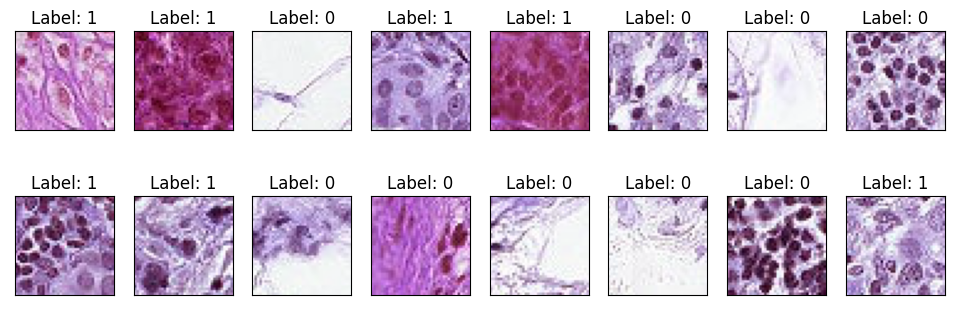

In [0]:
fig = plt.figure(figsize=(12, 4), dpi=100)
np.random.seed(777) #we can use the seed to get a different set of random images
for plotNr,idx in enumerate(np.random.randint(0,N,16)):
    ax = fig.add_subplot(2, 16//2, plotNr+1, xticks=[], yticks=[]) #add subplots
    plt.imshow(X[idx]) #plot image
    ax.set_title('Label: ' + str(y[idx])) #show the label corresponding to the image

Evaluate the distribution of the two classes

Text(0, 0.5, 'Samples')

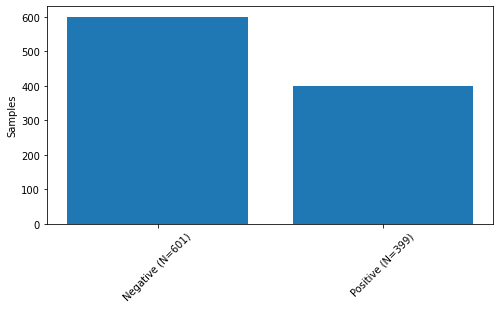

In [0]:
plt.figure(figsize=[8,4])
plt.bar([0,1], [(y==0).sum(), (y==1).sum()])
plt.axis()
plt.xticks([0,1],[f"Negative (N={(y==0).sum()})",f"Positive (N={(y==1).sum()})"],rotation=45)
#plt.xticks(rotation=45)
#plt.rc('xtick',labelsize=10)
plt.ylabel('Samples')


In [0]:
print(f"{round((y==1).sum()/len(y)*100,2)}% of the samples are positive.") 
print(f"We need to clear the baseline of {round((y==0).sum()/len(y)*100,2)}%, which would be the accuracy if we predicted that all of the samples were non-cancerous.")

39.9% of the samples are positive.
We need to clear the baseline of 60.1%, which would be the accuracy if we predicted that all of the samples were non-cancerous.


###To evaluate the classes individually

In [0]:
positive_samples = X[y == 1]
negative_samples = X[y == 0]

Look at the distribution of the pixels for each color channel

In [0]:
# nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
# fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

# #RGB channels
# axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
# axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
# axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
# axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
# axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
# axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)

# #All channels
# axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
# axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)

# #Set image labels
# axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
# axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
# axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
# axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
# axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
# axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
# for i in range(4):
#     axs[i,0].set_ylabel("Relative frequency")
# axs[3,0].set_xlabel("Pixel value")
# axs[3,1].set_xlabel("Pixel value")
# fig.tight_layout()

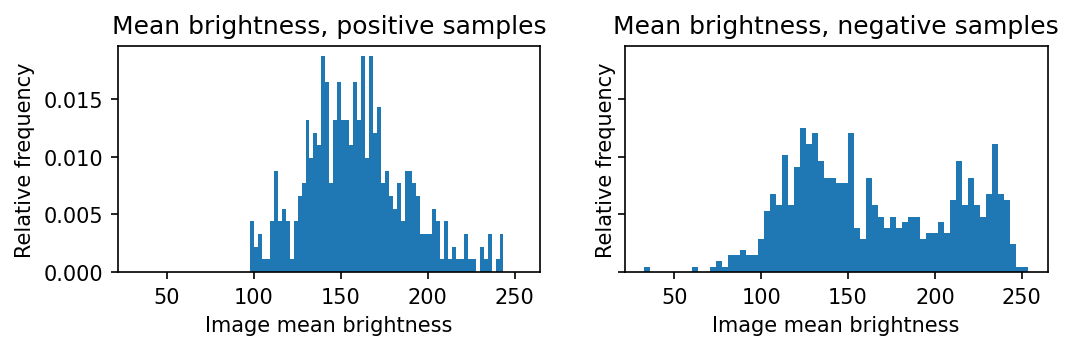

In [0]:
nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

In [0]:
#Clean up variables to free up RAM
#Collect garbage
positives_samples = None
negative_samples = None
gc.collect();

#Prepare data for modeling

In [0]:
#Load remainder of dataset
X = None
y = None
gc.collect();
#using df with same number of samples per class
N = df_equal["path"].size # get the number of images in the training data set
X,y = load_data(N=N,df=df)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


KeyboardInterrupt: ignored

In [0]:
X[1]

array([[[0.3726  , 0.011765, 0.1804  ],
        [0.498   , 0.1333  , 0.2864  ],
        [0.4785  , 0.102   , 0.2627  ],
        ...,
        [0.8433  , 0.4785  , 0.859   ],
        [0.541   , 0.2079  , 0.569   ],
        [0.698   , 0.3687  , 0.7373  ]],

       [[0.4785  , 0.1216  , 0.251   ],
        [0.4587  , 0.0902  , 0.2235  ],
        [0.4941  , 0.1216  , 0.2666  ],
        ...,
        [0.698   , 0.349   , 0.714   ],
        [0.714   , 0.3843  , 0.7295  ],
        [0.6274  , 0.2903  , 0.6587  ]],

       [[0.498   , 0.1608  , 0.2783  ],
        [0.4197  , 0.0706  , 0.2     ],
        [0.4666  , 0.1098  , 0.2627  ],
        ...,
        [0.8037  , 0.4626  , 0.8     ],
        [0.6235  , 0.302   , 0.6274  ],
        [0.714   , 0.3765  , 0.745   ]],

       ...,

       [[0.8667  , 0.5728  , 0.863   ],
        [0.5884  , 0.2705  , 0.6353  ],
        [0.5806  , 0.255   , 0.643   ],
        ...,
        [0.741   , 0.3726  , 0.651   ],
        [0.698   , 0.357   , 0.647   ],
        [

##Train test split

In [0]:
# Split into train and test (80/20)
from sklearn.model_selection import train_test_split
#not setting a random_state and not shuffling because samples are already shuffled and want to save RAM 
# added random state instead of shuffle=False
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 40, 40, 3), (2000, 40, 40, 3), (8000,), (2000,))

In [0]:
# X = None
# y = None
# gc.collect();

#Define callbacks for training/testing times

In [0]:
# Define callback to get total training time
import datetime

class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [0]:
# Define callback to get total test time
import datetime

class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

#Experiment 1:DNN
Establish a baseline

##Build and compile the model

In [0]:
model = models.Sequential()

model.add(layers.Flatten(input_shape=(40, 40, 3)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                48010     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 48,021
Trainable params: 48,021
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [0]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 6800 samples, validate on 1200 samples
Epoch 1/15
6800/6800 [==============================] - 2s 327us/step - loss: 0.6857 - accuracy: 0.5812 - val_loss: 0.6688 - val_accuracy: 0.5942
Epoch 2/15
6800/6800 [==============================] - 0s 58us/step - loss: 0.6713 - accuracy: 0.5896 - val_loss: 0.6601 - val_accuracy: 0.5942
Epoch 3/15
6800/6800 [==============================] - 0s 58us/step - loss: 0.6568 - accuracy: 0.5896 - val_loss: 0.6480 - val_accuracy: 0.5942
Epoch 4/15
6800/6800 [==============================] - 0s 59us/step - loss: 0.6505 - accuracy: 0.5896 - val_loss: 0.6420 - val_accuracy: 0.5942
Epoch 5/15
6800/6800 [==============================] - 0s 57us/step - loss: 0.6501 - accuracy: 0.5896 - val_loss: 0.6449 - val_accuracy: 0.5942
Epoch 6/15
6800/6800 [==============================] - 0s 59us/step - loss: 0.6438 - accuracy: 0.5896 - val_loss: 0.6519 - val_accuracy: 0.5942
Epoch 7/15
6800/6800 [==============================] - 0s 57us/step - loss: 0.64

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

7.819952

##Test the model

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

2000/2000 [==============================] - 0s 76us/step


(0.6423363008499146, 0.5914999842643738)

In [0]:
test_time = test_rt.process_time
test_time # in seconds

0.152592

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

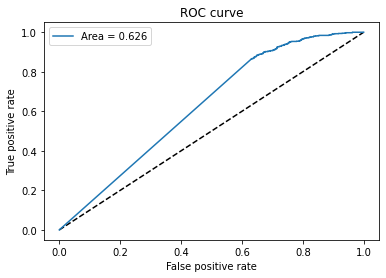

In [0]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Create a dataframe for the training and test statistics

In [0]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [0]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,val_loss,val_accuracy,loss,accuracy
10,0.639500,0.594167,0.644128,0.589559
11,0.634155,0.594167,0.640941,0.589559
12,0.635361,0.594167,0.641374,0.589559
13,0.635153,0.594167,0.640168,0.589559
14,0.641353,0.594167,0.643010,0.589559


In [0]:
results_df = history_df.iloc[-1:].copy()
results_df.insert(0,'model','DNN (1 layer)') 
results_df['test_loss'] = test_loss #incorporate test results
results_df['test_accuracy'] = test_acc
results_df['auroc'] = auc_keras
results_df['train time'] = train_time    
results_df['test time'] = test_time    
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,DNN (1 layer),0.641353,0.594167,0.64301,0.589559,0.642336,0.5915,0.625973,7.819952,0.152592


### Plotting the performance 

We use Matplotlib to create 2 plots--displaying the training and validation loss/accuracy for each training epoch side by side.

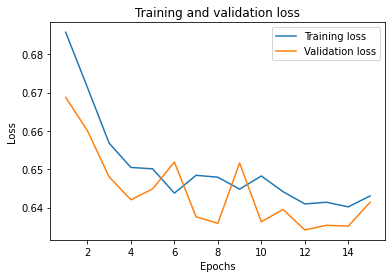

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

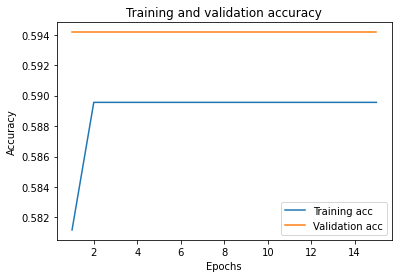

In [0]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Experiment 2, second DNN

This model is the same as in Experiment 1, but with an additional hidden layer. First hidden layer has 200 nodes, second hidden layer has 100 nodes.

##Build and compile the model

In [0]:
model = models.Sequential()

model.add(layers.Flatten(input_shape=(40, 40, 3)))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 200)               960200    
_________________________________________________________________
dense_10 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 980,401
Trainable params: 980,401
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [0]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=20,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/20
54400/54400 [==============================] - 5s 95us/step - loss: 0.6714 - accuracy: 0.5898 - val_loss: 0.6319 - val_accuracy: 0.5873
Epoch 2/20
54400/54400 [==============================] - 5s 93us/step - loss: 0.6328 - accuracy: 0.6116 - val_loss: 0.6315 - val_accuracy: 0.6265
Epoch 3/20
54400/54400 [==============================] - 5s 92us/step - loss: 0.6286 - accuracy: 0.6231 - val_loss: 0.6254 - val_accuracy: 0.6698
Epoch 4/20
54400/54400 [==============================] - 5s 94us/step - loss: 0.6235 - accuracy: 0.6311 - val_loss: 0.6304 - val_accuracy: 0.5894
Epoch 5/20
54400/54400 [==============================] - 5s 96us/step - loss: 0.6180 - accuracy: 0.6419 - val_loss: 0.6214 - val_accuracy: 0.6112
Epoch 6/20
54400/54400 [==============================] - 5s 96us/step - loss: 0.6089 - accuracy: 0.6561 - val_loss: 0.6045 - val_accuracy: 0.6624
Epoch 7/20
54400/54400 [==============================] - 5s 92us/ste

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

100.840272

##Test the model

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 2s 102us/step


(0.5879449455738067, 0.6938124895095825)

In [0]:
test_time = test_rt.process_time
test_time # in seconds

1.628008

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

###ROC and AUROC

In [0]:
auc_keras = auc(fpr, tpr)

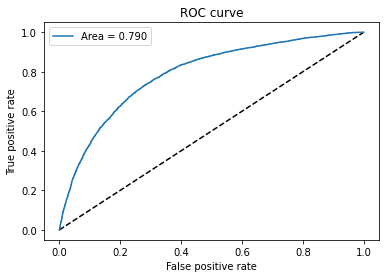

In [0]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [0]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','DNN (2 layer dropout)') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = ker
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
19,"DNN (1 layer, D)",0.62548,0.589167,0.632362,0.594596,0.623342,0.595563,0.649822,69.349039,1.669976


In [0]:
results_df=results_df.append(df,ignore_index=True)
results_df


,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,"CNN (2 layer, D)",0.414932,0.813125,0.368496,0.840717,0.416671,0.810812,0.889183,153.721501,2.190826
1,"DNN (1 layer, D)",0.625480,0.589167,0.632362,0.594596,0.623342,0.595563,0.649822,69.349039,1.669976


### Plotting the performance 


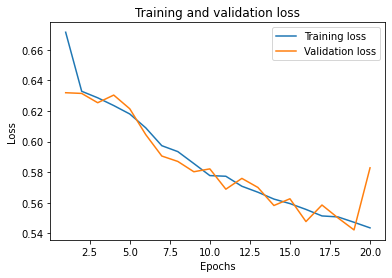

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

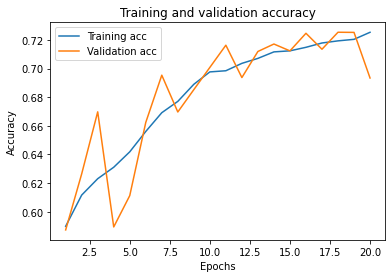

In [0]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Experiment 3: CNN with 2 convolutional layers

In [0]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, 40, 3)))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.2))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 38, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1048832   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [0]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 10s 188us/step - loss: 0.5214 - accuracy: 0.7446 - val_loss: 0.4841 - val_accuracy: 0.7769
Epoch 2/15
54400/54400 [==============================] - 6s 102us/step - loss: 0.4810 - accuracy: 0.7751 - val_loss: 0.4633 - val_accuracy: 0.7870
Epoch 3/15
54400/54400 [==============================] - 5s 100us/step - loss: 0.4668 - accuracy: 0.7824 - val_loss: 0.4792 - val_accuracy: 0.7735
Epoch 4/15
54400/54400 [==============================] - 5s 101us/step - loss: 0.4529 - accuracy: 0.7933 - val_loss: 0.4537 - val_accuracy: 0.7932
Epoch 5/15
54400/54400 [==============================] - 5s 100us/step - loss: 0.4385 - accuracy: 0.8010 - val_loss: 0.4382 - val_accuracy: 0.8080
Epoch 6/15
54400/54400 [==============================] - 5s 99us/step - loss: 0.4280 - accuracy: 0.8080 - val_loss: 0.4513 - val_accuracy: 0.7920
Epoch 7/15
54400/54400 [==============================] - 6s 10

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

87.033493

##Test the model

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 2s 115us/step


(0.5357609395086765, 0.792062520980835)

In [0]:
test_time = test_rt.process_time
test_time # in seconds

1.846106

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

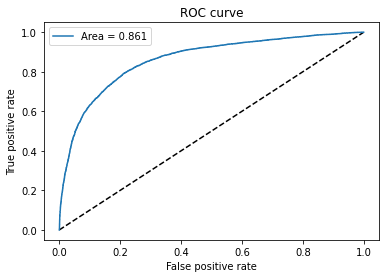

In [0]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [0]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','CNN (2 layers)') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
14,CNN (2 layers),0.523904,0.797708,0.234002,0.907776,0.535761,0.792063,87.033493,1.846106


In [0]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
0,DNN (1 layer),0.588970,0.679271,0.586518,0.689687,0.594717,0.670125,61.349588,1.563415
1,DNN (2 layer dropout),0.567190,0.709271,0.560058,0.709743,0.571902,0.712375,85.752367,1.706699
2,CNN (2 layers),0.523904,0.797708,0.234002,0.907776,0.535761,0.792063,87.033493,1.846106


### Plotting the performance 


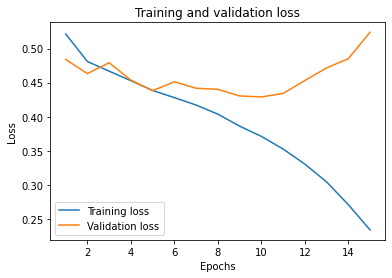

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

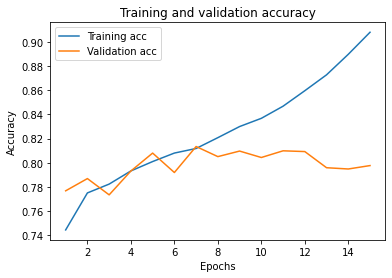

In [0]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Experiment 4: CNN with 2 convolutional layers, dropout

In [0]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, 40, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 38, 38, 32)        896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 19, 19, 32)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 17, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 4096)            

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [0]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 6800 samples, validate on 1200 samples
Epoch 1/15
6800/6800 [==============================] - 1s 125us/step - loss: 0.6409 - accuracy: 0.6126 - val_loss: 0.7222 - val_accuracy: 0.4508
Epoch 2/15
6800/6800 [==============================] - 1s 91us/step - loss: 0.5409 - accuracy: 0.7390 - val_loss: 0.5462 - val_accuracy: 0.7325
Epoch 3/15
6800/6800 [==============================] - 1s 91us/step - loss: 0.5241 - accuracy: 0.7557 - val_loss: 0.6019 - val_accuracy: 0.6708
Epoch 4/15
6800/6800 [==============================] - 1s 89us/step - loss: 0.5131 - accuracy: 0.7665 - val_loss: 0.5357 - val_accuracy: 0.7483
Epoch 5/15
6800/6800 [==============================] - 1s 91us/step - loss: 0.5057 - accuracy: 0.7700 - val_loss: 0.5313 - val_accuracy: 0.7458
Epoch 6/15
6800/6800 [==============================] - 1s 89us/step - loss: 0.5022 - accuracy: 0.7696 - val_loss: 0.5522 - val_accuracy: 0.7275
Epoch 7/15
6800/6800 [==============================] - 1s 89us/step - loss: 0.49

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

9.455829

##Test the model

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

2000/2000 [==============================] - 0s 96us/step


(0.5187002415657044, 0.7544999718666077)

In [0]:
test_time = test_rt.process_time
test_time # in seconds

0.191882

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

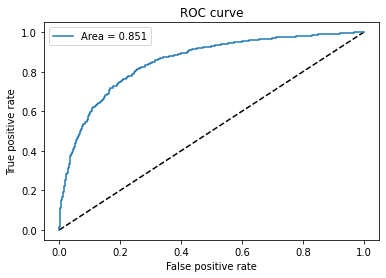

In [0]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [0]:
# results_df = history_df.iloc[-1:].copy()
# results_df.insert(0,'model','VGG16, 6 thawed batch100') 
# results_df['test_loss'] = test_loss #incorporate test results
# results_df['test_accuracy'] = test_acc
# results_df['auroc'] = auc_keras
# results_df['train time'] = train_time    
# results_df['test time'] = test_time    
# results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"VGG16, 6 thawed batch100",0.462399,0.79,0.398716,0.834118,0.511062,0.8015,0.876494,39.586958,0.565562


In [0]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','CNN 50') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,CNN 50,0.54601,0.730833,0.458783,0.790735,0.5187,0.7545,0.851425,9.455829,0.191882


In [0]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,CNN 100,0.481577,0.771667,0.395079,0.826912,0.452261,0.7930,0.864088,9.359693,0.208542
1,CNN 200,0.482114,0.776667,0.433950,0.810588,0.464697,0.7910,0.855162,9.694628,0.192393
2,CNN 256,0.495766,0.769167,0.432787,0.805147,0.468270,0.7875,0.854287,9.694730,0.202621
3,CNN 300,0.495867,0.769167,0.389829,0.830588,0.472394,0.7805,0.851380,9.887212,0.186014
4,CNN 50,0.546010,0.730833,0.458783,0.790735,0.518700,0.7545,0.851425,9.455829,0.191882


### Plotting the performance 


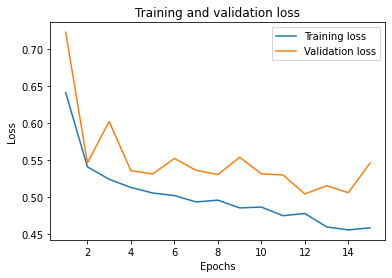

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

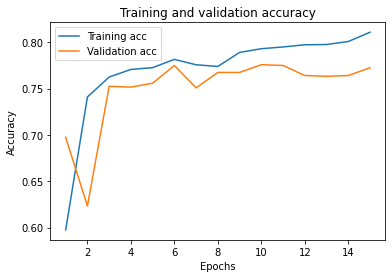

In [0]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###Confusion matrix
True (row) and predicted (column) values

In [0]:
# Get the predicted classes:
pred_classes = model.predict_classes(X_train)

In [0]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_train, pred_classes)
conf_mx

array([[4391,  331],
       [1265, 2013]])

#Feature Extraction

In [0]:
train_names[3]

'37f0d8cc90045cfe381b8000b8fbc5637c564778.tif'

In [0]:
# map sample image to array
img_path = train_path + '/' + train_names[3]

from keras.preprocessing import image                             

img = image.load_img(img_path, target_size=(40, 40))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.                                                
print(img_tensor.shape)  

(1, 40, 40, 3)


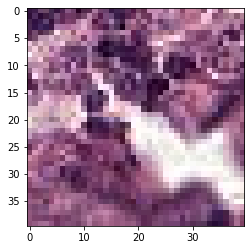

In [0]:
# display sample image
plt.imshow(img_tensor[0])
plt.show()

In [0]:
# instantiate a model from an input tensor and list of output tensors
layer_outputs = [layer.output for layer in model.layers[:8]]               
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [0]:
activations = activation_model.predict(img_tensor)

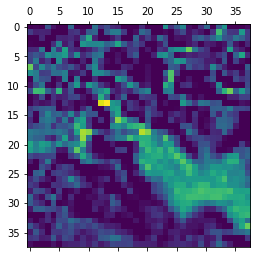

In [0]:
# activation of the first convolution layer for the sample image input
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

In [0]:
# every channel in every intermediate activation
layer_names = []                                                          
for layer in model.layers[:8]:                                            
    layer_names.append(layer.name)                                        

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):        
    n_features = layer_activation.shape[-1]                               

    size = layer_activation.shape[1]                                      

    n_cols = n_features // images_per_row                                 
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):                                             
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()                         
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,                   
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


#Export Results

In [0]:
#Export results dataframe

from google.colab import files

results_df.to_csv('PCam10k_denseLayer.csv')
files.download('PCam10k_denseLayer.csv')

#Pre-trained Network: VGG16

In [0]:
from keras.applications import VGG16

## VGG16 3 layers thawed

###Instantiate the model

Do not use dropout initially

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

58892288/58889256 [==============================] - 3s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [0]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 17s 310us/step - loss: 0.4729 - accuracy: 0.7848 - val_loss: 0.4289 - val_accuracy: 0.8045
Epoch 2/15
54400/54400 [==============================] - 16s 298us/step - loss: 0.4146 - accuracy: 0.8130 - val_loss: 0.4086 - val_accuracy: 0.8130
Epoch 3/15
54400/54400 [==============================] - 16s 299us/step - loss: 0.3969 - accuracy: 0.8210 - val_loss: 0.3999 - val_accuracy: 0.8195
Epoch 4/15
54400/54400 [==============================] - 16s 298us/step - loss: 0.3754 - accuracy: 0.8327 - val_loss: 0.4004 - val_accuracy: 0.8201
Epoch 5/15
54400/54400 [==============================] - 16s 299us/step - loss: 0.3617 - accuracy: 0.8416 - val_loss: 0.4019 - val_accuracy: 0.8241
Epoch 6/15
54400/54400 [==============================] - 16s 299us/step - loss: 0.3448 - accuracy: 0.8483 - val_loss: 0.4156 - val_accuracy: 0.8181
Epoch 7/15
54400/54400 [==============================] -

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

244.583603

###Test the model

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 5s 308us/step


(0.654116459608078, 0.8091874718666077)

In [0]:
test_time = test_rt.process_time
test_time # in seconds

4.925948

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

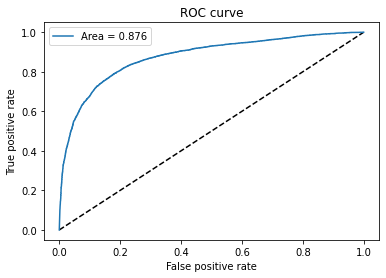

In [0]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [0]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 3 thawed') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
14,"VGG16, 3 thawed",0.651987,0.806562,0.196915,0.917794,0.654116,0.809187,244.583603,4.925948


In [0]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
0,DNN (1 layer),0.588970,0.679271,0.586518,0.689687,0.594717,0.670125,61.349588,1.563415
1,DNN (2 layer dropout),0.567190,0.709271,0.560058,0.709743,0.571902,0.712375,85.752367,1.706699
2,CNN (2 layers),0.523904,0.797708,0.234002,0.907776,0.535761,0.792063,87.033493,1.846106
3,"CNN (2 layers, D)",0.406787,0.817083,0.355217,0.846379,0.404930,0.821875,89.789792,1.926839
4,"VGG16, 3 thawed",0.651987,0.806562,0.196915,0.917794,0.654116,0.809187,244.583603,4.925948


### Plotting the performance 


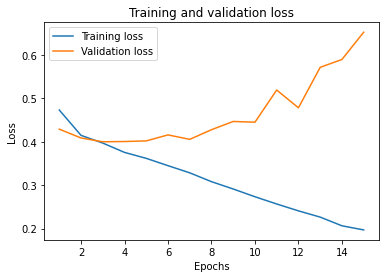

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

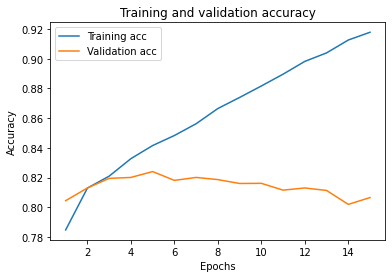

In [0]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##VGG16 3 layers with Dropout

In [0]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

58892288/58889256 [==============================] - 3s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [0]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 52s 950us/step - loss: 0.4571 - accuracy: 0.7900 - val_loss: 0.4183 - val_accuracy: 0.8080
Epoch 2/15
54400/54400 [==============================] - 50s 927us/step - loss: 0.4112 - accuracy: 0.8165 - val_loss: 0.4132 - val_accuracy: 0.8130
Epoch 3/15
54400/54400 [==============================] - 51s 928us/step - loss: 0.3895 - accuracy: 0.8270 - val_loss: 0.4137 - val_accuracy: 0.8117
Epoch 4/15
54400/54400 [==============================] - 50s 926us/step - loss: 0.3758 - accuracy: 0.8355 - val_loss: 0.4086 - val_accuracy: 0.8159
Epoch 5/15
54400/54400 [==============================] - 51s 929us/step - loss: 0.3603 - accuracy: 0.8444 - val_loss: 0.4146 - val_accuracy: 0.8173
Epoch 6/15
54400/54400 [==============================] - 50s 927us/step - loss: 0.3472 - accuracy: 0.8497 - val_loss: 0.4234 - val_accuracy: 0.8129
Epoch 7/15
54400/54400 [==============================] -

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

757.410375

###Test the model

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 12s 771us/step


(0.6457765243202448, 0.8058750033378601)

In [0]:
test_time = test_rt.process_time
test_time # in seconds

12.342323

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

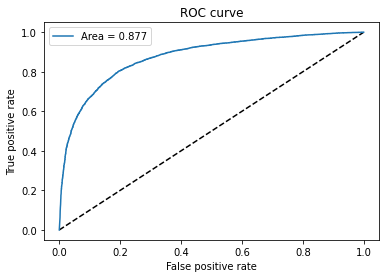

In [0]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [0]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 3 thawed, D') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"VGG16, 3 thawed, D",0.644842,0.813854,0.21415,0.912132,0.645777,0.805875,0.877119,757.410375,12.342323


In [0]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,"CNN (2 layer, D)",0.414932,0.813125,0.368496,0.840717,0.416671,0.810812,0.889183,153.721501,2.190826
1,"DNN (1 layer, D)",0.625480,0.589167,0.632362,0.594596,0.623342,0.595563,0.649822,69.349039,1.669976
2,"VGG16, 3 thawed, D",0.644842,0.813854,0.214150,0.912132,0.645777,0.805875,0.877119,757.410375,12.342323


### Plotting the performance 


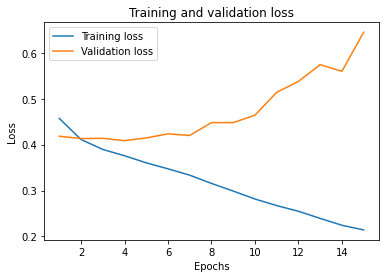

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

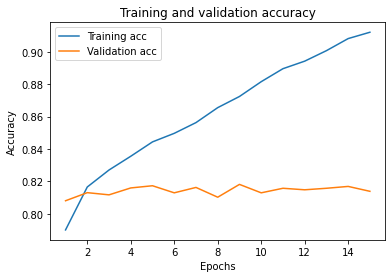

In [0]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##VGG16 unfreeze 6 convolutional layers (block 4 and block 5)

In [0]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [0]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 6800 samples, validate on 1200 samples
Epoch 1/15
6800/6800 [==============================] - 3s 485us/step - loss: 0.6251 - accuracy: 0.6741 - val_loss: 0.6019 - val_accuracy: 0.7183
Epoch 2/15
6800/6800 [==============================] - 3s 384us/step - loss: 0.4843 - accuracy: 0.7826 - val_loss: 0.5034 - val_accuracy: 0.7733
Epoch 3/15
6800/6800 [==============================] - 3s 382us/step - loss: 0.4685 - accuracy: 0.7900 - val_loss: 0.5202 - val_accuracy: 0.7617
Epoch 4/15
6800/6800 [==============================] - 3s 379us/step - loss: 0.4494 - accuracy: 0.8004 - val_loss: 0.5346 - val_accuracy: 0.7717
Epoch 5/15
6800/6800 [==============================] - 3s 383us/step - loss: 0.4440 - accuracy: 0.8003 - val_loss: 0.4705 - val_accuracy: 0.7933
Epoch 6/15
6800/6800 [==============================] - 3s 384us/step - loss: 0.4109 - accuracy: 0.8169 - val_loss: 0.4712 - val_accuracy: 0.7758
Epoch 7/15
6800/6800 [==============================] - 3s 385us/step - loss

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

39.872407

###Test the model

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

2000/2000 [==============================] - 1s 366us/step


(0.5121278140544891, 0.7950000166893005)

In [0]:
test_time = test_rt.process_time
test_time # in seconds

0.732316

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

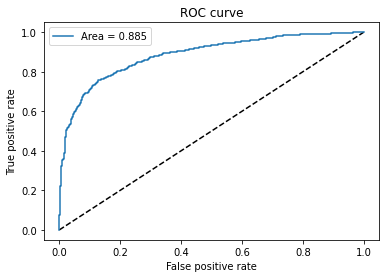

In [0]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [0]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 6 thawed') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"VGG16, 6 thawed",0.574106,0.786667,0.259928,0.897059,0.512128,0.795,0.884934,39.872407,0.732316


In [0]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,CNN 0.2,0.514086,0.755000,0.415115,0.812500,0.479403,0.7865,0.853903,15.920050,0.204955
1,CNN 0.3,0.478628,0.781667,0.431588,0.806765,0.459737,0.7930,0.861795,9.609255,0.186907
2,CNN 0.4,0.488802,0.775000,0.453660,0.793824,0.464849,0.7875,0.860706,9.924536,0.206625
3,CNN 0.5,0.499373,0.775833,0.469899,0.785882,0.473044,0.7900,0.856083,9.653379,0.207491
4,CNN 0.25,0.490139,0.767500,0.442153,0.798824,0.457407,0.7985,0.860512,9.705029,0.198612
5,"VGG16, 6 thawed",0.574106,0.786667,0.259928,0.897059,0.512128,0.7950,0.884934,39.872407,0.732316


### Plotting the performance 


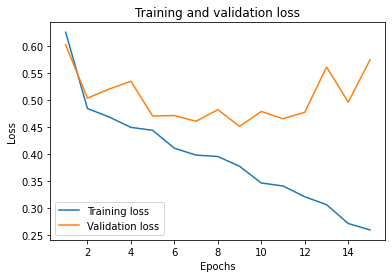

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

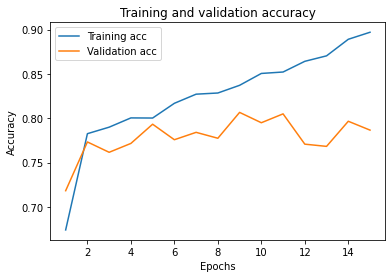

In [0]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##VGG16 unfreeze 6 convolutional layers (block 4 and block 5) with Dropout

In [0]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_23 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_44 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [0]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 50,
                    validation_split = 0.15)

Train on 6800 samples, validate on 1200 samples
Epoch 1/15
6800/6800 [==============================] - 4s 588us/step - loss: 0.3353 - accuracy: 0.8521 - val_loss: 2.2844 - val_accuracy: 0.7875
Epoch 2/15
6800/6800 [==============================] - 4s 565us/step - loss: 0.3864 - accuracy: 0.8349 - val_loss: 0.4994 - val_accuracy: 0.7825
Epoch 3/15
6800/6800 [==============================] - 4s 563us/step - loss: 0.3300 - accuracy: 0.8569 - val_loss: 0.5403 - val_accuracy: 0.7792
Epoch 4/15
6800/6800 [==============================] - 4s 566us/step - loss: 0.3148 - accuracy: 0.8619 - val_loss: 1.4904 - val_accuracy: 0.7642
Epoch 5/15
6800/6800 [==============================] - 4s 557us/step - loss: 0.3011 - accuracy: 0.8754 - val_loss: 0.5504 - val_accuracy: 0.7717
Epoch 6/15
6800/6800 [==============================] - 4s 556us/step - loss: 0.2612 - accuracy: 0.8951 - val_loss: 0.5932 - val_accuracy: 0.7750
Epoch 7/15
6800/6800 [==============================] - 4s 554us/step - loss

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

57.110854

###Test the model

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

2000/2000 [==============================] - 1s 279us/step


(0.7179410703182221, 0.7820000052452087)

In [0]:
test_time = test_rt.process_time
test_time # in seconds

0.559651

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

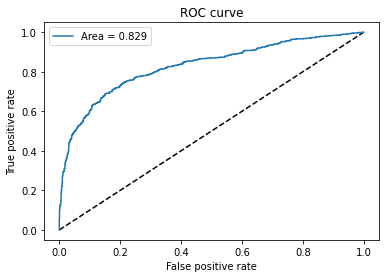

In [0]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [0]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 6 thawed batch50') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"VGG16, 6 thawed batch50",0.741815,0.785,0.115116,0.958676,0.717941,0.782,0.828922,57.110854,0.559651


In [0]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,"VGG16, 6 thawed batch100",0.462399,0.790,0.398716,0.834118,0.511062,0.8015,0.876494,39.586958,0.565562
1,"VGG16, 6 thawed batch50",0.741815,0.785,0.115116,0.958676,0.717941,0.7820,0.828922,57.110854,0.559651


### Plotting the performance 


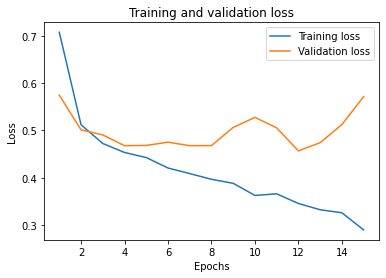

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

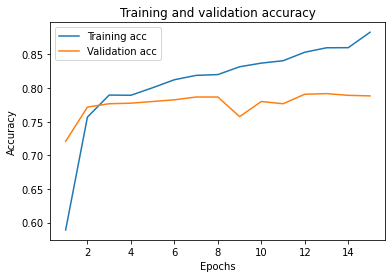

In [0]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##VGG16 unfreeze 9 convolutional layers (blocks 3, 4, 5)

In [0]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block3_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [0]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 85s 2ms/step - loss: 0.5721 - accuracy: 0.7096 - val_loss: 0.5046 - val_accuracy: 0.7682
Epoch 2/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4898 - accuracy: 0.7746 - val_loss: 0.4724 - val_accuracy: 0.7811
Epoch 3/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4592 - accuracy: 0.7919 - val_loss: 0.4359 - val_accuracy: 0.8048
Epoch 4/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4421 - accuracy: 0.8017 - val_loss: 0.4249 - val_accuracy: 0.8087
Epoch 5/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4196 - accuracy: 0.8138 - val_loss: 0.4495 - val_accuracy: 0.8014
Epoch 6/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4058 - accuracy: 0.8200 - val_loss: 0.4136 - val_accuracy: 0.8213
Epoch 7/15
54400/54400 [==============================] - 84s 2ms/ste

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

1260.76891

###Test the model

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 12s 727us/step


(0.3753491099178791, 0.8343124985694885)

In [0]:
test_time = test_rt.process_time
test_time # in seconds

11.634572

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

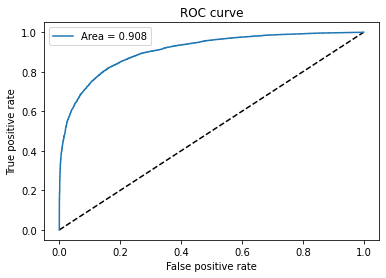

In [0]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [0]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 9 thawed') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"VGG16, 9 thawed",0.384486,0.836667,0.346331,0.849853,0.375349,0.834312,0.908232,1260.76891,11.634572


In [0]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,"CNN (2 layer, D)",0.414932,0.813125,0.368496,0.840717,0.416671,0.810812,0.889183,153.721501,2.190826
1,"DNN (1 layer, D)",0.625480,0.589167,0.632362,0.594596,0.623342,0.595563,0.649822,69.349039,1.669976
2,"VGG16, 3 thawed, D",0.644842,0.813854,0.214150,0.912132,0.645777,0.805875,0.877119,757.410375,12.342323
3,"VGG16, 6 thawed D",0.396917,0.833854,0.310740,0.868713,0.397511,0.831125,0.905549,1062.310632,11.847392
4,"VGG16, 9 thawed",0.384486,0.836667,0.346331,0.849853,0.375349,0.834312,0.908232,1260.768910,11.634572


### Plotting the performance 


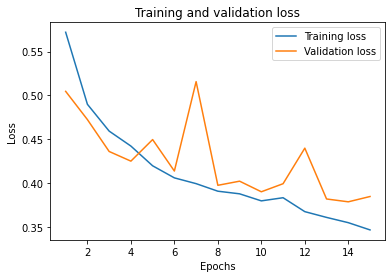

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

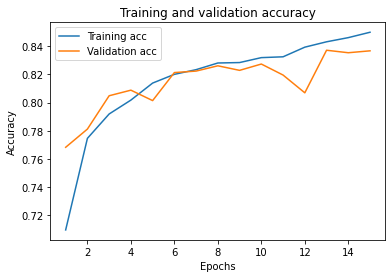

In [0]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##VGG16 unfreeze 9 convolutional layers (blocks 3, 4, 5) with Dropout

In [0]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block3_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [0]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 85s 2ms/step - loss: 0.5321 - accuracy: 0.7380 - val_loss: 0.4636 - val_accuracy: 0.7937
Epoch 2/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4598 - accuracy: 0.7915 - val_loss: 0.4507 - val_accuracy: 0.7981
Epoch 3/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4506 - accuracy: 0.7946 - val_loss: 0.4306 - val_accuracy: 0.8037
Epoch 4/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4260 - accuracy: 0.8087 - val_loss: 0.4268 - val_accuracy: 0.8082
Epoch 5/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4325 - accuracy: 0.8060 - val_loss: 0.4248 - val_accuracy: 0.8124
Epoch 6/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4191 - accuracy: 0.8120 - val_loss: 0.4224 - val_accuracy: 0.8104
Epoch 7/15
54400/54400 [==============================] - 84s 2ms/ste

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

1267.274439

###Test the model

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 12s 744us/step


(0.39206524920463565, 0.8302500247955322)

In [0]:
test_time = test_rt.process_time
test_time # in seconds

11.910122

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

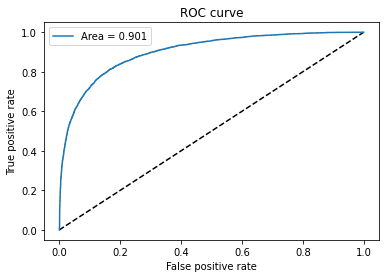

In [0]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [0]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 9 thawed') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"VGG16, 9 thawed",0.395351,0.828854,0.368661,0.839798,0.392065,0.83025,0.901231,1267.274439,11.910122


In [0]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,"CNN (2 layer, D)",0.414932,0.813125,0.368496,0.840717,0.416671,0.810812,0.889183,153.721501,2.190826
1,"DNN (1 layer, D)",0.625480,0.589167,0.632362,0.594596,0.623342,0.595563,0.649822,69.349039,1.669976
2,"VGG16, 3 thawed, D",0.644842,0.813854,0.214150,0.912132,0.645777,0.805875,0.877119,757.410375,12.342323
3,"VGG16, 6 thawed D",0.396917,0.833854,0.310740,0.868713,0.397511,0.831125,0.905549,1062.310632,11.847392
4,"VGG16, 9 thawed",0.384486,0.836667,0.346331,0.849853,0.375349,0.834312,0.908232,1260.768910,11.634572
5,"VGG16, 9 thawed",0.395351,0.828854,0.368661,0.839798,0.392065,0.830250,0.901231,1267.274439,11.910122


### Plotting the performance 


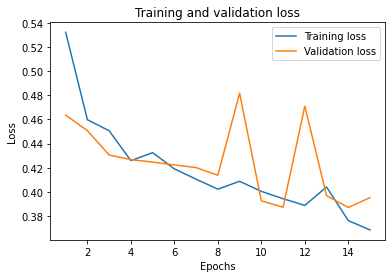

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

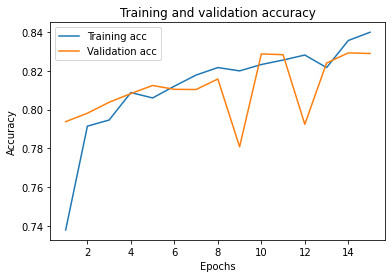

In [0]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Export results

In [0]:
#Export results dataframe

from google.colab import files

results_df.to_csv('PCam80k_resnet.csv')
files.download('PCam80k_resnet.csv')

#Visualizing findings

###Confusion matrix
True (row) and predicted (column) values

In [0]:
# Get the predicted classes:
pred_classes = model.predict_classes(X_train)

In [0]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_train, pred_classes)
conf_mx

array([[37130,   872],
       [ 1092, 24906]])

#Export results

In [0]:
#Export results dataframe

from google.colab import files

results_df.to_csv('PCam80k_resnet3_6.csv')
files.download('PCam80k_resnet3_6.csv')